# Packages & Functions

## Packages

In [1]:
import random

import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Functions

In [2]:
def scailing(x, y):

    ms = MinMaxScaler()
    ss = StandardScaler()

    x_ss = ss.fit_transform(x)
    y_ms = ms.fit_transform(y)

    return x_ss, y_ms

In [3]:
def window_sliding(x, y, iw, ow):
    
    x_ws, y_ws = list(), list()
    for i in range(len(df)):
        x_end = i + iw
        y_end = x_end + ow
        
        if y_end > len(df):
            break
        
        tx = x[i:x_end, :]
        ty = y[x_end:y_end, :]
        
        x_ws.append(tx)
        y_ws.append(ty)
    
    return torch.FloatTensor(x_ws).to(device), torch.FloatTensor(y_ws).to(device)

In [4]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [5]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []

        for data in train_loader:
            seq, target = data
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()

        for data in test_loader:
            seq, target = data
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
      
    total = train_pred + test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()


# Data Processing

## Load Data

In [6]:
data = pd.read_csv('../Data/train.csv')
print(data.dtypes)

Date      object
Open       int64
High       int64
Low        int64
Volume     int64
Close      int64
dtype: object


## Index & Col

In [7]:
df = data.loc[:, ['Date', 'Open']]
df.rename(columns = {'Open':'AC'}, inplace = True)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

In [8]:
df

,AC,DAC,DDAC
Date,,,
2015-12-16,120,NaN,NaN
2015-12-17,124,4.0,NaN
2015-12-18,121,-3.0,-7.0
2015-12-21,120,-1.0,2.0
2015-12-22,117,-3.0,-2.0
...,...,...,...
2019-10-14,284,-1.0,-20.0
2019-10-15,284,0.0,1.0
2019-10-16,283,-1.0,-1.0


,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


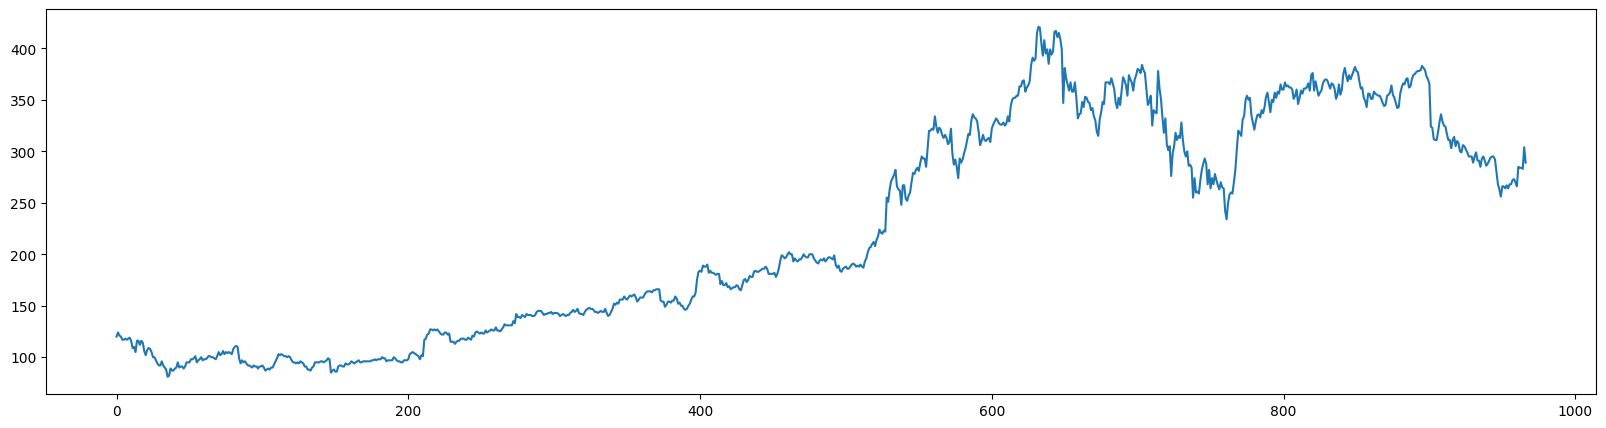

In [9]:
plt.figure(figsize=(20,5))
plt.plot(range(len(data)), df["AC"])
data.head()

## Null Values

In [10]:
df.isnull().sum()

AC      0
DAC     1
DDAC    2
dtype: int64

In [11]:
df.dropna(inplace = True)
df

,AC,DAC,DDAC
Date,,,
2015-12-18,121,-3.0,-7.0
2015-12-21,120,-1.0,2.0
2015-12-22,117,-3.0,-2.0
2015-12-23,117,0.0,3.0
2015-12-24,118,1.0,1.0
...,...,...,...
2019-10-14,284,-1.0,-20.0
2019-10-15,284,0.0,1.0
2019-10-16,283,-1.0,-1.0


## Split Target

In [12]:
x = df.iloc[:, 0:]
y = df.iloc[:,:1]
print(x)
print(y)

             AC   DAC  DDAC
Date                       
2015-12-18  121  -3.0  -7.0
2015-12-21  120  -1.0   2.0
2015-12-22  117  -3.0  -2.0
2015-12-23  117   0.0   3.0
2015-12-24  118   1.0   1.0
...         ...   ...   ...
2019-10-14  284  -1.0 -20.0
2019-10-15  284   0.0   1.0
2019-10-16  283  -1.0  -1.0
2019-10-17  304  21.0  22.0
2019-10-18  289 -15.0 -36.0

[965 rows x 3 columns]
             AC
Date           
2015-12-18  121
2015-12-21  120
2015-12-22  117
2015-12-23  117
2015-12-24  118
...         ...
2019-10-14  284
2019-10-15  284
2019-10-16  283
2019-10-17  304
2019-10-18  289

[965 rows x 1 columns]


## Scailing

In [13]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

In [14]:
x_ss, y_ms

(array([[-0.98782528, -0.46905606, -0.69755913],
        [-0.99740329, -0.17321351,  0.20183235],
        [-1.02613732, -0.46905606, -0.19789719],
        ...,
        [ 0.56381226, -0.17321351, -0.09796481],
        [ 0.76495046,  3.0810545 ,  2.20048009],
        [ 0.62128032, -2.24411134, -3.59559834]]),
 array([[0.11764706],
        [0.11470588],
        [0.10588235],
        [0.10588235],
        [0.10882353],
        [0.10588235],
        [0.10882353],
        [0.11176471],
        [0.10294118],
        [0.08235294],
        [0.08529412],
        [0.07058824],
        [0.10294118],
        [0.10294118],
        [0.09117647],
        [0.10294118],
        [0.09705882],
        [0.07352941],
        [0.06176471],
        [0.07647059],
        [0.08235294],
        [0.07941176],
        [0.07058824],
        [0.05588235],
        [0.05588235],
        [0.04705882],
        [0.03823529],
        [0.03235294],
        [0.03235294],
        [0.04411765],
        [0.03235294],
        [

## Window Slide

In [15]:
x = x.to_numpy()
y = y.to_numpy()
x, y = window_sliding(x, y, 60, 7)
x_ss, y_ms = window_sliding(x_ss, y_ms, 60, 7)

## Split Train & Test

In [16]:
x_train = x_ss[:650]
y_train = y_ms[:650]
x_test = x_ss[650:]
y_test = y_ms[650:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([650, 60, 3])
torch.Size([650, 7, 1])
torch.Size([249, 60, 3])
torch.Size([249, 7, 1])


## Data Loader

In [17]:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

# Model

## Define Model1

In [22]:
class encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device):
        super(encoder, self).__init__()
        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size = input_size, 
                          hidden_size = hidden_size, 
                          num_layers = num_layers, 
                          batch_first=True, 
                          dropout = 0.3)
        
    def forward(self, x):
        #print('Encoder')
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        #print("input_size: ", x.shape)
        out, hn = self.rnn(x, h0)
        #print("out_size: ", out.shape)
        #print("hidden_size: ", hn[0].shape)
        
        return out, hn

In [47]:
class decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device):
        super(decoder, self).__init__()
        self.device = device
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size = input_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          batch_first = True,
                          dropout = 0.3)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x, hn):
        #print('Decoder')
        #print("x_size: ", x.shape)
        x = x.unsqueeze(1)
        #print("x_input_size: ", x_input.shape)
        out, hn = self.rnn(x, hn)
        #print("out_size: ", out.shape)
        #print("hn_size: ", hn[0].shape)
        out = self.linear(out)
        #print("out_size: ", out.shape)
        
        return out, hn

In [53]:
class encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, device):
        super(encoder_decoder, self).__init__()
        self.device = device
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.encoder = encoder(input_size = input_size, 
                               hidden_size = hidden_size,
                               num_layers = num_layers,
                               dropout = 0.3,
                               device = device)
        
        self.decoder = decoder(input_size = input_size, 
                               hidden_size = hidden_size,
                               num_layers = num_layers,
                               dropout = 0.3,
                               device = device)

    def forward(self, x, y, target_len, teacher_forcing_ratio):
        batch_size = x.shape[0]
        input_size = x.shape[2]
        #print("x_size: ", x.shape)
        outputs = torch.zeros(batch_size, target_len, 1)
        #print("y_size: ", y.shape)
        #print('')
        
        #print("Encoding")
        _, hn = self.encoder(x)
        #print("_ size: ", _.shape)
        #print("hidden_size: ", hn[0].shape)
        decoder_input = x[:,-1, :]
        #print("decoder_input_size: ", decoder_input.shape)
        #print('')
        
        #print('Decoding')
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len): 
            out, hn = self.decoder(decoder_input, hn)
            #print("out_size: ", out.shape)
            out =  out.squeeze(1)
            #print("out_size: ", out.shape)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_output = y[:, t, :]
            else:
                decoder_output = out
            #print("out_size: ", out.shape)
            outputs[:,t,:] = out
            
            #decoder_input = 

        return outputs

In [32]:
input_size = 3
hidden_size = 8
num_layers = 1


model = encoder_decoder(input_size = input_size, 
                        hidden_size = hidden_size,
                        dropout = 0.25,
                        device = device).to(device)


criterion = nn.MSELoss()
lr = 1e-6
num_epochs = 10000
optimizer = Adam(model.parameters(), lr = lr)
patience = 10

In [492]:
loss_list = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        seq, target = data
        out = model(seq, target, 7, 0.5).to(device)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss/n)
    if (epoch+1) % 100 == 0:
        print('epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
        
    if (epoch % patience == 0) & (epoch != 0):
            
            if loss_list[epoch-patience] < loss_list[epoch]:
                print('\n Early Stopping / epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
                
                break


 Early Stopping / epoch: 31 loss: 0.0050


## Visualize Loss Graph

**Loss**가 파도처럼 물결침 ->  **patience**를 늘려 **early stop** 간격을 조금 더 길게 두고 본다. <br>
**RNN**이기 때문에 **LSTM**으로 변환 시 달라질 수도 있다.

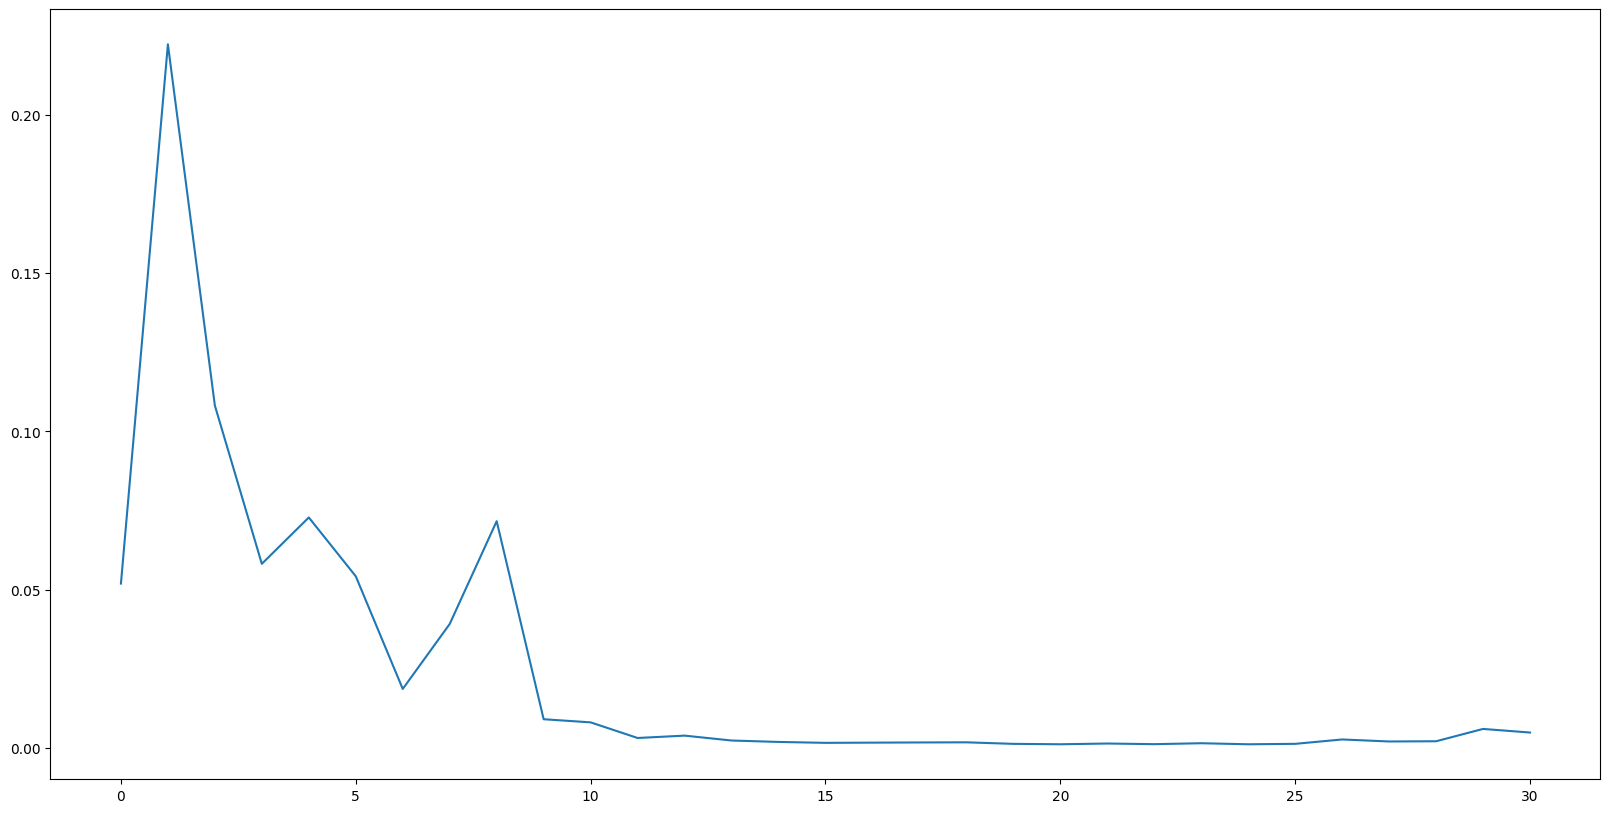

In [493]:
plt.figure(figsize = (20, 10))
plt.plot(loss_list)
plt.show()

In [494]:
loss_list

[0.051966504299674525,
 0.2222243853929368,
 0.10817813814025033,
 0.058210477317598736,
 0.07284774555062706,
 0.054278226526962084,
 0.018716320776465265,
 0.03922117826401849,
 0.07167391098019751,
 0.009151753842491995,
 0.008162282999943603,
 0.0032297242485748775,
 0.003976323948749764,
 0.0024336865039499985,
 0.001982416568683799,
 0.001695123763056472,
 0.0017612254014238715,
 0.0018187108719509772,
 0.0018599819608921694,
 0.0013776246447708797,
 0.0012494051096093078,
 0.001481590119179931,
 0.0012789494622583416,
 0.0015751862070332704,
 0.0012446303748716177,
 0.0013825798629444432,
 0.0027630437702596696,
 0.0021290302353339607,
 0.0021976575689305637,
 0.006089217467392286,
 0.0049524271955967624]

## Model Save and Load

In [495]:
PATH = "./Timeseries_seq2seq_1_COVID-19_daily_.pth"
torch.save(model.state_dict(), PATH)

In [496]:
PATH = "./Timeseries_seq2seq_1_COVID-19_daily_.pth"
model = encoder_decoder(input_size = input_size, 
                             output_size = output_size, 
                             hidden_size = hidden_size,
                             dropout = 0.25,
                             device = device).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

encoder_decoder(
  (encoder): encoder(
    (rnn): RNN(3, 8, batch_first=True, dropout=0.3)
    (relu): ReLU()
    (fc1): Linear(in_features=480, out_features=1, bias=True)
  )
  (decoder): decoder(
    (rnn): RNN(1, 8, batch_first=True, dropout=0.3)
    (linear): Linear(in_features=8, out_features=1, bias=True)
  )
)

## Visualize and Compare predicted values with actual values

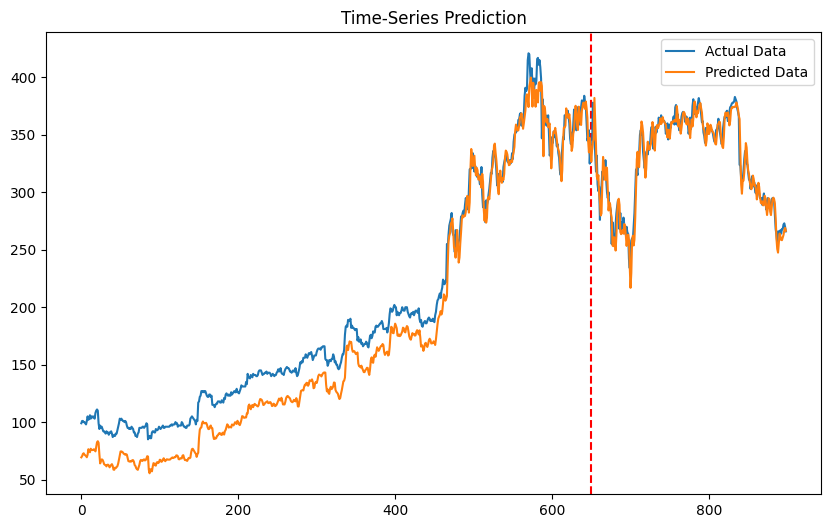

In [497]:
train_predict = model(x_ss, y_ms, 7, 0.5)
predicted = train_predict.cpu().data.numpy()
label_y = y_ms.cpu().data.numpy()

# 시각화를 위해 첫 날 예측값만을 가져옴
# 더 나은 방법이 있다면 수용할 필요가 있음
first_predicted = predicted[:, 0, :].reshape(899, 1)
first_label_y = label_y[:, 0, :].reshape(899, 1)

first_predicted = ms.inverse_transform(first_predicted)
first_label_y = ms.inverse_transform(first_label_y)

plt.figure(figsize = (10, 6))
plt.axvline(x = 650, c = 'r', linestyle = '--')

plt.plot(first_label_y, label = 'Actual Data')
plt.plot(first_predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## Caculate MAE

In [498]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(predicted, label_y))

MAE SCORE :  0.15582588


# Predict

In [499]:
ran = random.randrange(650, 899)
ran

892

In [500]:
pre7 = ms.inverse_transform(predicted.reshape(899, 7))
lab7 = ms.inverse_transform(label_y.reshape(899, 7))

predicted_final = np.vstack((first_predicted[:ran], pre7[ran].reshape(7, 1)))
label_y_final = np.vstack((first_label_y[:ran], lab7[ran].reshape(7, 1)))

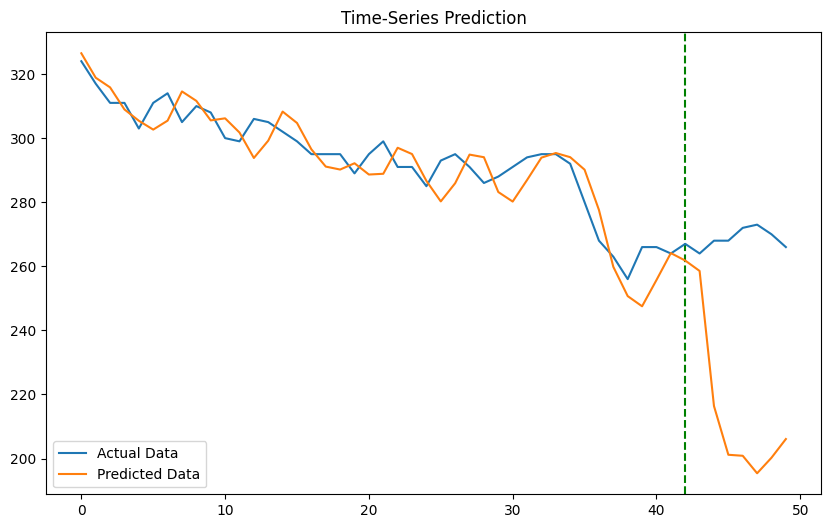

In [501]:
plt.figure(figsize = (10, 6)) 
plt.axvline(x = 42, c = 'g', linestyle = '--')

plt.plot(label_y_final[-50:], label = 'Actual Data')
plt.plot(predicted_final[-50:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

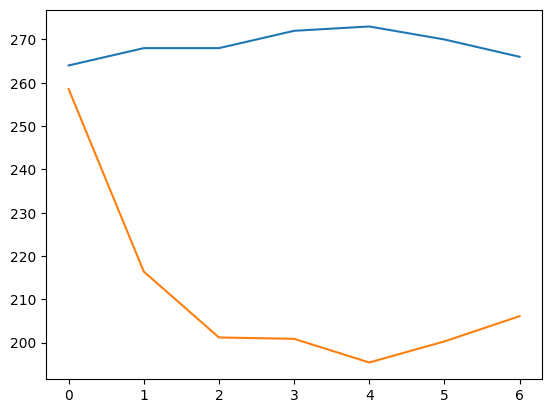

In [502]:
plt.plot(lab7[ran], label = 'Actual Data')
plt.plot(pre7[ran], label = 'Predicted Data')
plt.show()